In [1]:
import math 

import numpy as np
import pandas as pd

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

from sklearn.feature_extraction.text import TfidfTransformer

The scikit-learn version is 0.23.1.


In [2]:
df_data_train = pd.read_csv('./Amazon_Review_Data/amazon_review_ID.shuf.lrn.csv', low_memory=False, sep=',')
df_data_test = pd.read_csv('./Amazon_Review_Data/amazon_review_ID.shuf.tes.csv', low_memory=False, sep=',')

In [3]:
df_data_train.head()

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000,Class
0,0,8,6,10,6,7,2,2,2,3,...,1,0,0,0,0,0,0,0,0,Chell
1,1,13,1,13,9,8,8,2,3,2,...,4,1,2,1,0,1,0,0,0,Engineer
2,2,16,7,6,7,9,3,4,2,6,...,0,0,0,0,1,0,0,0,0,Grove
3,3,8,11,10,11,3,7,0,4,2,...,0,0,1,0,0,0,2,1,0,Davisson
4,4,10,11,8,5,3,4,2,5,5,...,0,0,0,0,0,0,0,0,0,Wilson


## Class Distribution

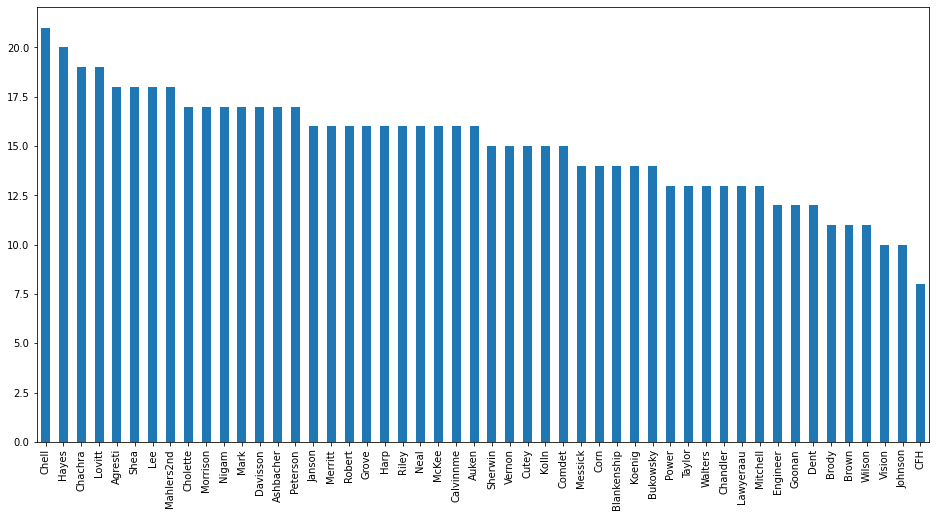

In [4]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,8))
df_data_train['Class'].value_counts().plot(kind='bar')
plt.show()

## Dataframe Pre-Processing

In [5]:
df_train = df_data_train.copy()

class_factor = df_data_train['Class'].factorize()
class_index = class_factor[1]

df_train['ClassF'] = class_factor[0]

columns = sorted(set(df_data_train.columns) - set(['ID', 'Class', 'ClassF']))

X = df_train[columns].to_numpy()
y = df_train['ClassF'].to_numpy()


X_test = df_data_test[columns]

## TDIF Transformation

In [6]:
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X)
X_test_tfidf = tfidf.transform(X_test)

print(X_tfidf.shape)

unique_classes = np.unique(y)
print(len(unique_classes))

(750, 10000)
50


In [7]:
np.eye(len(unique_classes), dtype='uint8')[y]

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

## PyTorch

### CV Model

In [16]:
import time
import torch 
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, make_scorer, accuracy_score, balanced_accuracy_score, f1_score

def create_model():
    num_inputs = 10000
    num_outputs = 50
    return nn.Sequential(
        nn.Linear(num_inputs, 1000),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(1000, num_outputs),
        nn.Sigmoid()
    )

def nn_fit_and_predict(X_cv_train, y_cv_train, X_cv_test, y_cv_test):
    nX = torch.from_numpy(X_cv_train.todense()).float()
    nX_test = torch.from_numpy(X_cv_test.todense()).float()
    ny = torch.from_numpy(y_cv_train)
    ny_test = torch.from_numpy(y_cv_test)

    # Train network
    model = create_model()

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

    for epoch in range(200):
        y_pred = model(nX)

        loss = criterion(y_pred, ny)

        y_pred_a = torch.argmax(y_pred, dim=1).detach().numpy()
        accuracy = accuracy_score(y_pred_a, ny)
        
        y_pred_test = model(nX_test)
        y_pred_a_test = torch.argmax(y_pred_test, dim=1).detach().numpy()
        accuracy_test = accuracy_score(y_pred_a_test, ny_test)

        print('epoch: ', epoch,' loss: ', loss.item(),' accuracy(train): ', accuracy,' accuracy(test): ', accuracy_test)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

    # Finally predict test
    y_output = model(nX_test)
    y_prediction = torch.argmax(y_output, dim=1).detach().numpy()
    return y_prediction


cv_results_accuracy = []
cv_results_balanced_accuracy = []
cv_results_f1_weighted = []
    
cv_fold = KFold(n_splits=5, random_state=0, shuffle=True)

time_start = time.time()

for train_index, test_index in cv_fold.split(X):
    X_cv_train = X_tfidf[train_index,:]
    X_cv_test = X_tfidf[test_index,:]
    
    y_cv_train = y[train_index]
    y_cv_test = y[test_index]
    
    y_cv_test_pred = nn_fit_and_predict(X_cv_train, y_cv_train, X_cv_test, y_cv_test)
    
    cv_results_accuracy.append(accuracy_score(y_cv_test, y_cv_test_pred))
    cv_results_balanced_accuracy.append(balanced_accuracy_score(y_cv_test, y_cv_test_pred))
    cv_results_f1_weighted.append(f1_score(y_cv_test, y_cv_test_pred, average='weighted'))
    
time_end = time.time()
    
cv_results = {
    'Type': 'MLP',
    'accuracy': np.array(cv_results_accuracy).mean(),
    'accuracy_sd': np.std(np.array(cv_results_accuracy)),
    'balanced_accuracy': np.array(cv_results_balanced_accuracy).mean(),
    'balanced_accuracy_sd': np.std(np.array(cv_results_balanced_accuracy)),
    'f1_weighted': np.array(cv_results_f1_weighted).mean(),
    'f1_weighted_sd': np.std(np.array(cv_results_f1_weighted)),
}
print(cv_results)
print('time: %s' % (time_end - time_start))

epoch:  0  loss:  3.9121766090393066  accuracy(train):  0.011666666666666667  accuracy(test):  0.02
epoch:  1  loss:  3.8886373043060303  accuracy(train):  0.195  accuracy(test):  0.02
epoch:  2  loss:  3.849843740463257  accuracy(train):  0.065  accuracy(test):  0.02666666666666667
epoch:  3  loss:  3.815432548522949  accuracy(train):  0.055  accuracy(test):  0.02666666666666667
epoch:  4  loss:  3.758972644805908  accuracy(train):  0.06166666666666667  accuracy(test):  0.03333333333333333
epoch:  5  loss:  3.6922688484191895  accuracy(train):  0.115  accuracy(test):  0.03333333333333333
epoch:  6  loss:  3.614495038986206  accuracy(train):  0.5566666666666666  accuracy(test):  0.05333333333333334
epoch:  7  loss:  3.527050733566284  accuracy(train):  0.9433333333333334  accuracy(test):  0.32666666666666666
epoch:  8  loss:  3.441265344619751  accuracy(train):  0.9583333333333334  accuracy(test):  0.32666666666666666
epoch:  9  loss:  3.361298084259033  accuracy(train):  0.95833333333

epoch:  76  loss:  2.9524855613708496  accuracy(train):  0.9933333333333333  accuracy(test):  0.5666666666666667
epoch:  77  loss:  2.95249080657959  accuracy(train):  0.9933333333333333  accuracy(test):  0.6066666666666667
epoch:  78  loss:  2.952510356903076  accuracy(train):  0.9933333333333333  accuracy(test):  0.62
epoch:  79  loss:  2.952479362487793  accuracy(train):  0.9933333333333333  accuracy(test):  0.6466666666666666
epoch:  80  loss:  2.95247483253479  accuracy(train):  0.9933333333333333  accuracy(test):  0.62
epoch:  81  loss:  2.952483892440796  accuracy(train):  0.9933333333333333  accuracy(test):  0.62
epoch:  82  loss:  2.952484130859375  accuracy(train):  0.9933333333333333  accuracy(test):  0.6266666666666667
epoch:  83  loss:  2.9524829387664795  accuracy(train):  0.9933333333333333  accuracy(test):  0.62
epoch:  84  loss:  2.952488899230957  accuracy(train):  0.9933333333333333  accuracy(test):  0.6133333333333333
epoch:  85  loss:  2.9525041580200195  accuracy(

epoch:  151  loss:  2.9524006843566895  accuracy(train):  0.9933333333333333  accuracy(test):  0.6466666666666666
epoch:  152  loss:  2.9524078369140625  accuracy(train):  0.9933333333333333  accuracy(test):  0.5933333333333334
epoch:  153  loss:  2.9524009227752686  accuracy(train):  0.9933333333333333  accuracy(test):  0.64
epoch:  154  loss:  2.952406406402588  accuracy(train):  0.9933333333333333  accuracy(test):  0.5933333333333334
epoch:  155  loss:  2.9524013996124268  accuracy(train):  0.9933333333333333  accuracy(test):  0.6
epoch:  156  loss:  2.9523935317993164  accuracy(train):  0.9933333333333333  accuracy(test):  0.6266666666666667
epoch:  157  loss:  2.9523980617523193  accuracy(train):  0.9933333333333333  accuracy(test):  0.6066666666666667
epoch:  158  loss:  2.9523913860321045  accuracy(train):  0.9933333333333333  accuracy(test):  0.6333333333333333
epoch:  159  loss:  2.9524011611938477  accuracy(train):  0.9933333333333333  accuracy(test):  0.62
epoch:  160  loss:

/usr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


epoch:  0  loss:  3.9117634296417236  accuracy(train):  0.023333333333333334  accuracy(test):  0.013333333333333334
epoch:  1  loss:  3.88700270652771  accuracy(train):  0.11333333333333333  accuracy(test):  0.03333333333333333
epoch:  2  loss:  3.848374128341675  accuracy(train):  0.10333333333333333  accuracy(test):  0.02666666666666667
epoch:  3  loss:  3.8151321411132812  accuracy(train):  0.08666666666666667  accuracy(test):  0.02666666666666667
epoch:  4  loss:  3.76188063621521  accuracy(train):  0.11  accuracy(test):  0.02666666666666667
epoch:  5  loss:  3.6944961547851562  accuracy(train):  0.25  accuracy(test):  0.04666666666666667
epoch:  6  loss:  3.620084524154663  accuracy(train):  0.7566666666666667  accuracy(test):  0.15333333333333332
epoch:  7  loss:  3.5382885932922363  accuracy(train):  0.905  accuracy(test):  0.35333333333333333
epoch:  8  loss:  3.455301523208618  accuracy(train):  0.9166666666666666  accuracy(test):  0.34
epoch:  9  loss:  3.377531051635742  acc

epoch:  86  loss:  2.955739736557007  accuracy(train):  0.99  accuracy(test):  0.6
epoch:  87  loss:  2.955714225769043  accuracy(train):  0.99  accuracy(test):  0.5933333333333334
epoch:  88  loss:  2.9557108879089355  accuracy(train):  0.99  accuracy(test):  0.6266666666666667
epoch:  89  loss:  2.955703020095825  accuracy(train):  0.99  accuracy(test):  0.6266666666666667
epoch:  90  loss:  2.955737829208374  accuracy(train):  0.99  accuracy(test):  0.64
epoch:  91  loss:  2.9557085037231445  accuracy(train):  0.99  accuracy(test):  0.6266666666666667
epoch:  92  loss:  2.955698013305664  accuracy(train):  0.99  accuracy(test):  0.6266666666666667
epoch:  93  loss:  2.9556891918182373  accuracy(train):  0.99  accuracy(test):  0.6266666666666667
epoch:  94  loss:  2.955681085586548  accuracy(train):  0.99  accuracy(test):  0.6066666666666667
epoch:  95  loss:  2.9556922912597656  accuracy(train):  0.99  accuracy(test):  0.58
epoch:  96  loss:  2.9557249546051025  accuracy(train):  0.

epoch:  174  loss:  2.9556124210357666  accuracy(train):  0.99  accuracy(test):  0.6066666666666667
epoch:  175  loss:  2.955620050430298  accuracy(train):  0.99  accuracy(test):  0.6266666666666667
epoch:  176  loss:  2.95562744140625  accuracy(train):  0.99  accuracy(test):  0.62
epoch:  177  loss:  2.955608606338501  accuracy(train):  0.99  accuracy(test):  0.6333333333333333
epoch:  178  loss:  2.955615758895874  accuracy(train):  0.99  accuracy(test):  0.62
epoch:  179  loss:  2.9556069374084473  accuracy(train):  0.99  accuracy(test):  0.6466666666666666
epoch:  180  loss:  2.955596685409546  accuracy(train):  0.99  accuracy(test):  0.5866666666666667
epoch:  181  loss:  2.955618381500244  accuracy(train):  0.99  accuracy(test):  0.6
epoch:  182  loss:  2.955615520477295  accuracy(train):  0.99  accuracy(test):  0.5933333333333334
epoch:  183  loss:  2.9556102752685547  accuracy(train):  0.99  accuracy(test):  0.6466666666666666
epoch:  184  loss:  2.955599308013916  accuracy(tra

/usr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


epoch:  0  loss:  3.9120235443115234  accuracy(train):  0.02666666666666667  accuracy(test):  0.02666666666666667
epoch:  1  loss:  3.8871257305145264  accuracy(train):  0.1  accuracy(test):  0.04
epoch:  2  loss:  3.8451099395751953  accuracy(train):  0.04  accuracy(test):  0.02666666666666667
epoch:  3  loss:  3.810004472732544  accuracy(train):  0.03166666666666667  accuracy(test):  0.02
epoch:  4  loss:  3.752054452896118  accuracy(train):  0.03  accuracy(test):  0.02
epoch:  5  loss:  3.6806466579437256  accuracy(train):  0.06  accuracy(test):  0.02
epoch:  6  loss:  3.6023316383361816  accuracy(train):  0.36333333333333334  accuracy(test):  0.08
epoch:  7  loss:  3.5175912380218506  accuracy(train):  0.8833333333333333  accuracy(test):  0.24666666666666667
epoch:  8  loss:  3.434847831726074  accuracy(train):  0.92  accuracy(test):  0.31333333333333335
epoch:  9  loss:  3.3583426475524902  accuracy(train):  0.9216666666666666  accuracy(test):  0.26
epoch:  10  loss:  3.2901659011

epoch:  88  loss:  2.9460208415985107  accuracy(train):  1.0  accuracy(test):  0.6866666666666666
epoch:  89  loss:  2.9460206031799316  accuracy(train):  1.0  accuracy(test):  0.6666666666666666
epoch:  90  loss:  2.9460372924804688  accuracy(train):  1.0  accuracy(test):  0.6666666666666666
epoch:  91  loss:  2.946026563644409  accuracy(train):  1.0  accuracy(test):  0.6466666666666666
epoch:  92  loss:  2.946002960205078  accuracy(train):  1.0  accuracy(test):  0.68
epoch:  93  loss:  2.945997476577759  accuracy(train):  1.0  accuracy(test):  0.64
epoch:  94  loss:  2.946014165878296  accuracy(train):  1.0  accuracy(test):  0.6533333333333333
epoch:  95  loss:  2.9460067749023438  accuracy(train):  1.0  accuracy(test):  0.6666666666666666
epoch:  96  loss:  2.9460017681121826  accuracy(train):  1.0  accuracy(test):  0.6533333333333333
epoch:  97  loss:  2.9460136890411377  accuracy(train):  1.0  accuracy(test):  0.6666666666666666
epoch:  98  loss:  2.9459967613220215  accuracy(trai

epoch:  176  loss:  2.945943593978882  accuracy(train):  1.0  accuracy(test):  0.6933333333333334
epoch:  177  loss:  2.9459433555603027  accuracy(train):  1.0  accuracy(test):  0.6333333333333333
epoch:  178  loss:  2.945932388305664  accuracy(train):  1.0  accuracy(test):  0.68
epoch:  179  loss:  2.9459402561187744  accuracy(train):  1.0  accuracy(test):  0.6266666666666667
epoch:  180  loss:  2.945953607559204  accuracy(train):  1.0  accuracy(test):  0.68
epoch:  181  loss:  2.9459357261657715  accuracy(train):  1.0  accuracy(test):  0.68
epoch:  182  loss:  2.9459385871887207  accuracy(train):  1.0  accuracy(test):  0.6733333333333333
epoch:  183  loss:  2.945919990539551  accuracy(train):  1.0  accuracy(test):  0.6866666666666666
epoch:  184  loss:  2.9459340572357178  accuracy(train):  1.0  accuracy(test):  0.64
epoch:  185  loss:  2.9459354877471924  accuracy(train):  1.0  accuracy(test):  0.6866666666666666
epoch:  186  loss:  2.945946455001831  accuracy(train):  1.0  accuracy

epoch:  62  loss:  2.9557669162750244  accuracy(train):  0.99  accuracy(test):  0.62
epoch:  63  loss:  2.9557337760925293  accuracy(train):  0.99  accuracy(test):  0.5466666666666666
epoch:  64  loss:  2.955744504928589  accuracy(train):  0.99  accuracy(test):  0.58
epoch:  65  loss:  2.955744504928589  accuracy(train):  0.99  accuracy(test):  0.58
epoch:  66  loss:  2.9557619094848633  accuracy(train):  0.99  accuracy(test):  0.5866666666666667
epoch:  67  loss:  2.9557323455810547  accuracy(train):  0.99  accuracy(test):  0.6133333333333333
epoch:  68  loss:  2.955747127532959  accuracy(train):  0.99  accuracy(test):  0.5533333333333333
epoch:  69  loss:  2.955735206604004  accuracy(train):  0.99  accuracy(test):  0.54
epoch:  70  loss:  2.9557294845581055  accuracy(train):  0.99  accuracy(test):  0.5933333333333334
epoch:  71  loss:  2.955731153488159  accuracy(train):  0.99  accuracy(test):  0.6
epoch:  72  loss:  2.955717086791992  accuracy(train):  0.99  accuracy(test):  0.56
ep

epoch:  151  loss:  2.955613613128662  accuracy(train):  0.99  accuracy(test):  0.6333333333333333
epoch:  152  loss:  2.955608606338501  accuracy(train):  0.99  accuracy(test):  0.5933333333333334
epoch:  153  loss:  2.9556117057800293  accuracy(train):  0.99  accuracy(test):  0.64
epoch:  154  loss:  2.955612897872925  accuracy(train):  0.99  accuracy(test):  0.62
epoch:  155  loss:  2.955605983734131  accuracy(train):  0.99  accuracy(test):  0.6066666666666667
epoch:  156  loss:  2.955613136291504  accuracy(train):  0.99  accuracy(test):  0.58
epoch:  157  loss:  2.955613851547241  accuracy(train):  0.99  accuracy(test):  0.6133333333333333
epoch:  158  loss:  2.9556169509887695  accuracy(train):  0.99  accuracy(test):  0.5866666666666667
epoch:  159  loss:  2.9556100368499756  accuracy(train):  0.99  accuracy(test):  0.5866666666666667
epoch:  160  loss:  2.9556190967559814  accuracy(train):  0.99  accuracy(test):  0.6
epoch:  161  loss:  2.9556076526641846  accuracy(train):  0.99 

/usr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


epoch:  0  loss:  3.9119796752929688  accuracy(train):  0.008333333333333333  accuracy(test):  0.013333333333333334
epoch:  1  loss:  3.887962579727173  accuracy(train):  0.03333333333333333  accuracy(test):  0.013333333333333334
epoch:  2  loss:  3.850940465927124  accuracy(train):  0.03166666666666667  accuracy(test):  0.013333333333333334
epoch:  3  loss:  3.816729784011841  accuracy(train):  0.03166666666666667  accuracy(test):  0.013333333333333334
epoch:  4  loss:  3.7655558586120605  accuracy(train):  0.03333333333333333  accuracy(test):  0.013333333333333334
epoch:  5  loss:  3.6984355449676514  accuracy(train):  0.03666666666666667  accuracy(test):  0.013333333333333334
epoch:  6  loss:  3.6268839836120605  accuracy(train):  0.13833333333333334  accuracy(test):  0.02666666666666667
epoch:  7  loss:  3.5455565452575684  accuracy(train):  0.6566666666666666  accuracy(test):  0.12666666666666668
epoch:  8  loss:  3.4593582153320312  accuracy(train):  0.9366666666666666  accuracy(

epoch:  86  loss:  2.946068286895752  accuracy(train):  1.0  accuracy(test):  0.58
epoch:  87  loss:  2.946080207824707  accuracy(train):  1.0  accuracy(test):  0.5533333333333333
epoch:  88  loss:  2.946052074432373  accuracy(train):  1.0  accuracy(test):  0.5866666666666667
epoch:  89  loss:  2.946049451828003  accuracy(train):  1.0  accuracy(test):  0.56
epoch:  90  loss:  2.946059226989746  accuracy(train):  1.0  accuracy(test):  0.58
epoch:  91  loss:  2.946053981781006  accuracy(train):  1.0  accuracy(test):  0.5866666666666667
epoch:  92  loss:  2.9460580348968506  accuracy(train):  1.0  accuracy(test):  0.6066666666666667
epoch:  93  loss:  2.946042537689209  accuracy(train):  1.0  accuracy(test):  0.62
epoch:  94  loss:  2.9460456371307373  accuracy(train):  1.0  accuracy(test):  0.5866666666666667
epoch:  95  loss:  2.946038007736206  accuracy(train):  1.0  accuracy(test):  0.58
epoch:  96  loss:  2.9460458755493164  accuracy(train):  1.0  accuracy(test):  0.6133333333333333


epoch:  174  loss:  2.9459662437438965  accuracy(train):  1.0  accuracy(test):  0.6066666666666667
epoch:  175  loss:  2.9459686279296875  accuracy(train):  1.0  accuracy(test):  0.58
epoch:  176  loss:  2.945948600769043  accuracy(train):  1.0  accuracy(test):  0.62
epoch:  177  loss:  2.945955991744995  accuracy(train):  1.0  accuracy(test):  0.6266666666666667
epoch:  178  loss:  2.945949077606201  accuracy(train):  1.0  accuracy(test):  0.6
epoch:  179  loss:  2.945955514907837  accuracy(train):  1.0  accuracy(test):  0.58
epoch:  180  loss:  2.9459645748138428  accuracy(train):  1.0  accuracy(test):  0.5466666666666666
epoch:  181  loss:  2.945974588394165  accuracy(train):  1.0  accuracy(test):  0.5666666666666667
epoch:  182  loss:  2.9459478855133057  accuracy(train):  1.0  accuracy(test):  0.5866666666666667
epoch:  183  loss:  2.9459612369537354  accuracy(train):  1.0  accuracy(test):  0.5733333333333334
epoch:  184  loss:  2.9459595680236816  accuracy(train):  1.0  accuracy(

/usr/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1814: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


## Predict on Test dataset

In [11]:
import torch 
import torch.nn as nn
from sklearn.metrics import accuracy_score

nX = torch.from_numpy(X_tfidf.todense()).float()
ny = torch.from_numpy(y)


nX_test = torch.from_numpy(X_test_tfidf.todense()).float()

model = create_model()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

for epoch in range(200):
    y_pred = model(nX)

    loss = criterion(y_pred, ny)
    
    y_pred_a = torch.argmax(y_pred, dim=1).detach().numpy()
    accuracy = accuracy_score(y_pred_a, ny)
    
    print('epoch: ', epoch,' loss: ', loss.item(),' accuracy: ', accuracy)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


epoch:  0  loss:  3.9119296073913574  accuracy:  0.016
epoch:  1  loss:  3.894451379776001  accuracy:  0.08666666666666667
epoch:  2  loss:  3.8648056983947754  accuracy:  0.08533333333333333
epoch:  3  loss:  3.8358750343322754  accuracy:  0.052
epoch:  4  loss:  3.7978479862213135  accuracy:  0.05466666666666667
epoch:  5  loss:  3.7504520416259766  accuracy:  0.09066666666666667
epoch:  6  loss:  3.684314012527466  accuracy:  0.33866666666666667
epoch:  7  loss:  3.6230928897857666  accuracy:  0.7266666666666667
epoch:  8  loss:  3.549659490585327  accuracy:  0.8413333333333334
epoch:  9  loss:  3.4757132530212402  accuracy:  0.872
epoch:  10  loss:  3.4141016006469727  accuracy:  0.864
epoch:  11  loss:  3.3538095951080322  accuracy:  0.8706666666666667
epoch:  12  loss:  3.29276442527771  accuracy:  0.912
epoch:  13  loss:  3.251150131225586  accuracy:  0.9293333333333333
epoch:  14  loss:  3.2006676197052  accuracy:  0.9573333333333334
epoch:  15  loss:  3.1646506786346436  accur

epoch:  146  loss:  2.9463796615600586  accuracy:  1.0
epoch:  147  loss:  2.9464242458343506  accuracy:  1.0
epoch:  148  loss:  2.9463846683502197  accuracy:  1.0
epoch:  149  loss:  2.9463284015655518  accuracy:  1.0
epoch:  150  loss:  2.9463672637939453  accuracy:  1.0
epoch:  151  loss:  2.946363925933838  accuracy:  1.0
epoch:  152  loss:  2.9464709758758545  accuracy:  1.0
epoch:  153  loss:  2.9463753700256348  accuracy:  1.0
epoch:  154  loss:  2.9463534355163574  accuracy:  1.0
epoch:  155  loss:  2.9464495182037354  accuracy:  1.0
epoch:  156  loss:  2.9463303089141846  accuracy:  1.0
epoch:  157  loss:  2.9463748931884766  accuracy:  1.0
epoch:  158  loss:  2.946347236633301  accuracy:  1.0
epoch:  159  loss:  2.9463584423065186  accuracy:  1.0
epoch:  160  loss:  2.946349859237671  accuracy:  1.0
epoch:  161  loss:  2.946288824081421  accuracy:  1.0
epoch:  162  loss:  2.9463934898376465  accuracy:  1.0
epoch:  163  loss:  2.9462852478027344  accuracy:  1.0
epoch:  164  l

## Predict Solution

In [12]:
# Predict
y_output = model(nX_test)
y_prediction = torch.argmax(y_output, dim=1).detach().numpy()
y_prediction

array([36, 38, 17, 43,  1, 10,  8, 30, 27, 27, 29, 20,  9, 22, 38, 44,  9,
       45, 22, 46, 16, 32, 22, 13, 29, 48, 47, 24, 11, 42, 35, 35, 29, 15,
        4, 27, 10, 30, 27, 49, 21,  4,  8, 13, 46, 32, 21, 31, 12, 23, 33,
        7, 12, 15, 21, 41, 31, 23, 33,  1, 29, 45, 24, 40, 10, 11, 16, 30,
       45, 39,  6, 30, 34, 36, 32, 29, 25, 21,  6, 32, 45, 37, 36, 38, 40,
        1, 24, 32, 43, 38, 27, 31, 18, 39, 45, 37, 46, 18, 37, 45, 49, 26,
       43, 44, 24, 35, 10, 46, 29, 35, 20, 40, 39, 44, 36, 49, 37, 35, 44,
       31,  6, 30, 42, 31, 28, 26,  9, 25, 33, 18, 27,  1, 21, 12, 42,  8,
       34, 44, 17, 22,  2, 12, 39, 37, 24, 38, 43, 20, 17,  1, 30, 42, 31,
       45,  9, 25, 43,  1, 20, 29, 45, 48, 24, 47, 39, 29, 33, 46, 22, 17,
        0, 29, 45, 34,  4, 18, 39, 21,  2, 29,  8, 46, 17,  9, 17, 17, 41,
       30, 21, 21, 11, 22, 15, 17,  2, 26, 24, 20, 15,  6, 19,  2, 28, 31,
       39, 24, 36, 15,  4, 12,  9, 41, 39, 44, 17, 15, 47, 11, 42, 37, 30,
       10, 33, 21, 23, 10

,Class
ID,
750,Blankenship
751,Hayes
752,Goonan
753,Dent
754,Engineer
...,...
1495,Cholette
1496,Comdet
1497,Lawyeraau


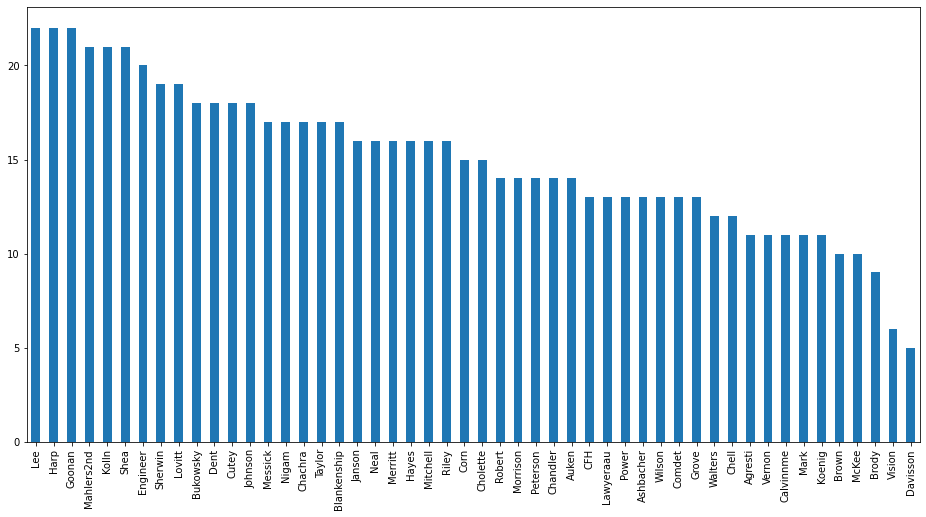

In [13]:
df_solution_test = pd.DataFrame(df_data_test['ID'])
df_solution_test['Class'] = [class_index[p] for p in y_prediction]
df_solution_test = df_solution_test.set_index('ID')

df_solution_test.to_csv('solution_test_nn.csv')

display(df_solution_test)


# Class distribution
fig = plt.figure(figsize=(16,8))
df_solution_test['Class'].value_counts().plot(kind='bar')
plt.show()

## VotingClassifier¶

#### SVC

In [53]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

# SVC (TF-IDF)
c = OneVsRestClassifier(SVC(C=9.75, kernel='rbf', probability=True))
c.fit(X_tfidf, y)

# Predict
y_prediction_svc = c.predict_proba(X_test_tfidf)
y_prediction_svc

array([[1.22700544e-05, 1.83871601e-04, 7.30216406e-03, ...,
        6.58552736e-05, 3.79377350e-05, 3.01355075e-05],
       [3.01771024e-05, 3.18205443e-04, 8.58248498e-04, ...,
        2.61653207e-04, 2.00459522e-04, 7.06157847e-03],
       [6.71203206e-05, 1.40674432e-03, 1.07459275e-03, ...,
        2.44275431e-04, 1.68137236e-04, 4.17696232e-03],
       ...,
       [1.66431744e-03, 7.60264047e-04, 3.76949300e-03, ...,
        1.24807555e-04, 1.71515396e-03, 2.26585706e-03],
       [2.02023167e-02, 2.75908106e-04, 7.45770681e-01, ...,
        1.85814713e-03, 1.01799229e-02, 1.70826913e-04],
       [5.25433846e-03, 6.11026454e-04, 2.97593162e-03, ...,
        1.32511065e-05, 3.53072768e-04, 1.26105351e-04]])

In [54]:
np.sum(y_prediction_svc[0])

0.9999999999999998

#### Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier

# RandomForest (TF-IDF)
c = OneVsRestClassifier(RandomForestClassifier(n_estimators=500, max_depth=10, criterion='entropy'))
c.fit(X_tfidf, y)

# Predict
y_prediction_rf = c.predict_proba(X_test_tfidf)
y_prediction_rf

array([[0.0095498 , 0.0095498 , 0.01500682, ..., 0.        , 0.00682128,
        0.00136426],
       [0.02131783, 0.00581395, 0.02131783, ..., 0.00968992, 0.00387597,
        0.01356589],
       [0.00290684, 0.01733786, 0.01733786, ..., 0.01155857, 0.01444822,
        0.0202275 ],
       ...,
       [0.00263817, 0.00527633, 0.03165799, ..., 0.        , 0.0079145 ,
        0.00527633],
       [0.05711541, 0.00316404, 0.08542914, ..., 0.01898425, 0.01898425,
        0.00632808],
       [0.0394921 , 0.00631723, 0.01737239, ..., 0.00473792, 0.00157931,
        0.01421377]])

In [30]:
np.sum(y_prediction_rf[0])

0.9999999999999996

#### MLP

In [31]:
def normalize_output(array_in):
    norm = np.linalg.norm(array_in, ord=1)
    return array_in/norm

y_prediction_nn = normalize_output(y_output[0].detach().numpy())
print(np.sum(y_prediction_nn))

0.99999994


In [98]:
y_prediction_vote = []


df_voting = pd.DataFrame()
for i in range(0, len(y_prediction_rf)):
    y_prediction_svc_v = y_prediction_svc[i]
    max_idx_svc = np.argmax(y_prediction_svc_v)
    max_pred_svc = y_prediction_svc_v[max_idx_svc]
    
    y_prediction_rf_v = y_prediction_rf[i]
    max_idx_rf = np.argmax(y_prediction_rf_v)
    max_pred_rf = y_prediction_rf_v[max_idx_rf]
    
    
    y_prediction_nn_v = normalize_output(y_output[i].detach().numpy())
    max_idx_nn = np.argmax(y_prediction_nn_v)
    max_pred_nn = y_prediction_nn_v[max_idx_nn]

    a = 1.0 # weight SVC
    b = 0.0 # weight RF
    c = 1.0 # weight NN
    
    y_prediction_vote_v = [y_prediction_svc_v[idx] * a + y_prediction_rf_v[idx] * b + y_prediction_nn_v[idx] * c for idx in range(0, len(y_prediction_rf_v))]
    
    max_idx_vote = np.argmax(y_prediction_vote_v)
    max_pred_vote = y_prediction_vote_v[max_idx_vote]
    
    y_prediction_vote.append(max_idx_vote)
    
    df_voting = df_voting.append({
        'svc_max_idx': max_idx_svc,
        'svc_max': max_pred_svc,
        'rf_max_idx': max_idx_rf,
        'rf_max': max_pred_rf,
        'nn_max_idx': max_idx_nn,
        'nn_max': max_pred_nn,
        'vote_max_idx': max_idx_vote,
        'vote_max': max_pred_vote
    }, ignore_index=True)
    
df_voting.to_csv('voting_test.csv')

display(df_voting[df_voting['nn_max_idx'] != df_voting['rf_max_idx']])

df_voting[df_voting['nn_max_idx'] != df_voting['rf_max_idx']].to_csv('voting_test_diff.csv')

,nn_max,nn_max_idx,rf_max,rf_max_idx,svc_max,svc_max_idx,vote_max,vote_max_idx
9,0.952351,27.0,0.078200,47.0,0.435220,27.0,1.387571,27.0
12,0.304616,34.0,0.066119,0.0,0.379854,3.0,0.412722,3.0
15,0.883773,44.0,0.058106,29.0,0.495009,42.0,0.958397,44.0
16,0.240137,0.0,0.039857,21.0,0.254991,4.0,0.376456,4.0
19,0.907796,46.0,0.062778,0.0,0.304144,46.0,1.211941,46.0
...,...,...,...,...,...,...,...,...
736,0.158773,16.0,0.070093,33.0,0.269460,24.0,0.290001,24.0
744,0.772241,14.0,0.062356,16.0,0.420014,16.0,0.948736,14.0
745,0.606828,42.0,0.062022,28.0,0.496044,42.0,1.102872,42.0
746,0.523986,1.0,0.067974,23.0,0.349634,34.0,0.709551,1.0


,Class
ID,
750,Blankenship
751,Hayes
752,Goonan
753,Dent
754,Engineer
...,...
1495,Corn
1496,Engineer
1497,Lawyeraau


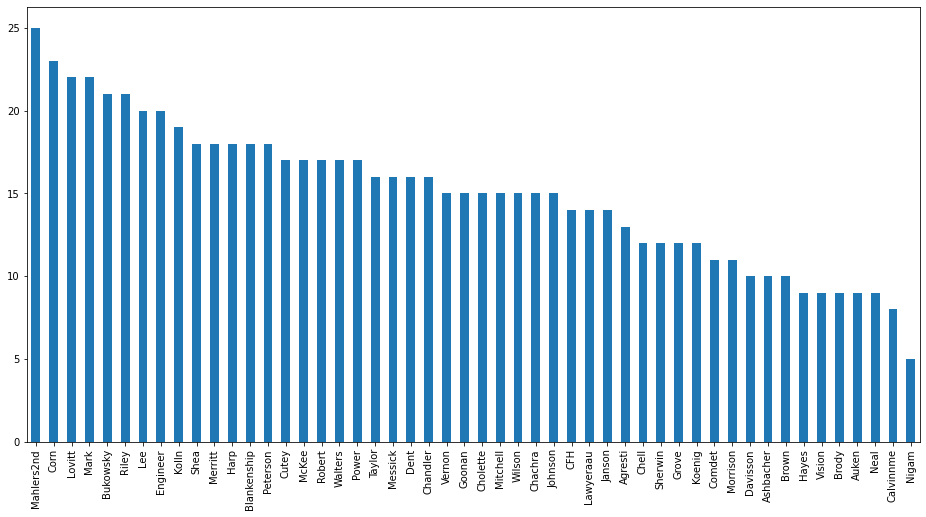

In [99]:
df_voting_solution_test = pd.DataFrame(df_data_test['ID'])
df_voting_solution_test['Class'] = [class_index[p] for p in y_prediction_vote]
df_voting_solution_test = df_voting_solution_test.set_index('ID')
df_voting_solution_test

df_voting_solution_test.to_csv('solution_test_vote.csv')

display(df_voting_solution_test)


# Class distribution
fig = plt.figure(figsize=(16,8))
df_voting_solution_test['Class'].value_counts().plot(kind='bar')
plt.show()